 # M1.2 Linear and Logistic Regression

 [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m1_2_linear_and_logistic_regression.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m1_2_linear_and_logistic_regression.ipynb)  


 ### Learning Objectives
By working through this notebook, you will be able to answer the questions:
  1. What is supervised learning, what properties does it contain?
  2. What is linear regression and how is it used to predict numbers?
  3. What is logistic regression and how can we use it to predict categories?
  4. How can we interpret model coefficients?
  5. How can we the algorithms on a real datasets from HuggingFace?

 ## 1. Introduction to Supervised Learning
 In the previous notebook, we learned how to convert our data into features using `DictVectorizer`. Now we'll use those features to actually **predict** things!

 **Supervised Learning** means we have:
 - **Features (X)**: The input data (what we know)
 - **Labels (y)**: The output we want to predict (what we want to learn)
- **Model**: A function that maps X → y (e.g., linear regression, logistic regression)
- **Loss Function**: A way to measure how wrong our predictions are, which we minimize during training

The goal is to learn a model that accurately maps X → y, so we can predict y for new, unseen data.

 Today we'll cover two fundamental algorithms:
 - **Linear Regression**: For predicting numbers (e.g., word frequency, text length)
 - **Logistic Regression**: For predicting categories (e.g., positive/negative sentiment, spam/not spam)

## 2. Linear Regression
Linear regression finds the best straight line (or hyperplane in higher dimensions) that fits your data. Think of it as finding the trend in your data.

We will now first introduce a toy regression task and afterward provide a proper formalization of Linear Regression.

### Example 1: Linear Regression - Predicting the number of unique words in a sentence
 Let's start with a simple example to understand what's happening:
-  **Example**: Finding the trend how many unique words there are for a sentence of N total words. So actually this result will measure how often words are repeated as well, as the number of unique words can never surpass the number of total words.

#### Loading the data
- While the Number of Unique Words task is very simple and could be applied to many types of text, we will load a classical movie review dataset, which is used for sentiment analysis (though we only look at the movie reviews for now, not the sentiment labels). 

In [1]:
# ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

# Load relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [2]:
# Load a simple sentiment dataset, we'll use the 'yelp_review_full' dataset which contains reviews with ratings from 1 to 5
# We load the test split (which has 50k examples), as it is smaller than the train split (which has 650k examples)
dataset_yelp = load_dataset('Yelp/yelp_review_full', split='test')
dataset_yelp = dataset_yelp.shuffle(seed=42)

# take the first 100 examples for quicker processing
dataset = dataset_yelp.select(range(1000))

#### _Intermezzo_: Loading Datasets
To load our datasets via the function `load_dataset()` we only used a single line of code! 
By now you may appeciate that we did not have to go through the trouble of downloading a file on the internet and creating a specific dataloader class, which is the standard case. 

The load_datasset() uses Huggingface, a great online resource that not only hosts datasets but also AI models and makes it really easy to use. You can also check out the website here: https://huggingface.co/datasets/stanfordnlp/imdb . Notice how the URL also has the same id "stanfordnlp/imdb". If you're curious go check out the website and see if you can load other datasets and models.




In [3]:
#  Also in this case we can index the dataset and obtain a dictionary with the text and labels
text = [item['text'] for item in dataset]
labels = [item['label'] for item in dataset]

dataset[0]

{'label': 2,
 'text': 'Kabuto is your run-of-the-mill Japanese Steakhouse. Different stations with chefs slinging shrimp tails around the communal dining areas like it\'s a lunchtime magic show. Always a plethora of laughs and gags going around the group. \\n\\nThis place is great for lunch. $9 and 30 minutes and you\'re out the door. Uhhh...If I\'m craving a salad with ginger dressing, which I always am, (you do too. admit it) fried rice, steak, shrimp and white sauce (DUDE) then Kabuto is king of lunch options in my book. Always super clean and full of kindhearted staff. The parking lot is super difficult to get in and out of though. 51 traffic at lunch is a beast. Good luck getting stuck behind someone trying to cut across traffic at 12pm on a weekday. It\'s murder. This place would greatly benefit from another exit/entrance or a stoplight. Here\'s hoping....\\n\\nYou can\'t really shake a stick at balanced lunch when you can have soup or a salad, veggies, fried rice and a choice of

#### Load number of unique words and sentence lengths
So we create two lists here, and for each sentence index _i_, we have 
- `text_length`: the total number of words in this sentence (split on spaces)
- `unique_words`: the number of unique words in the sentence (so no doubles)

In [4]:
# We only take the first sentence (split on "." ) for each review
sentences = [item['text'].split(".")[0] for item in dataset]

text_length = np.array([len(sentence.split()) for sentence in sentences]).reshape(-1, 1) 
unique_words = np.array([len(set(word.lower() for word in sentence.split())) for sentence in sentences])

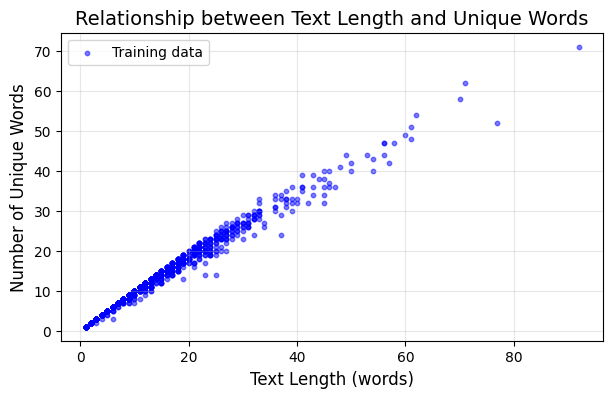

In [5]:
# Visualize the data
plt.figure(figsize=(7, 4))
plt.scatter(text_length, unique_words, color='blue', s=10, alpha=0.5, label='Training data')
plt.xlabel('Text Length (words)', fontsize=12)
plt.ylabel('Number of Unique Words', fontsize=12)
plt.title('Relationship between Text Length and Unique Words', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Observation:** Looking at this plot, we can see there's a clear and predictable relationship: the longer the text the more unique words it has. But how do we find the exact line that best describes this relationship?


#### Formalization: The Linear Regression Model

Now that we have an idea of the task setup, let's formalize what the Linear Regression algorithm does and implement it. We'll use the scikit-learn library ([see the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)).

**How Linear Regression Works**

Recall from the introduction that in supervised learning, we have the input features **X** (input) that we use to predict labels **y** (output). Linear regression learns a set of **weights** (also called the _learnable parameters_) that define how to combine the features to make predictions.

Consider a single data instance with **N** features: $[x_1, x_2, ..., x_N]$. Linear regression predicts the output $\hat{y}$ as a **weighted sum** of these features:

$$\hat{y} = w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + ... + w_N \cdot x_N$$

We can write this more compactly using summation notation:

$$\hat{y} = w_0 + \sum_{i=1}^{N} w_i \cdot x_i$$

**Understanding the notation:**
- $\hat{y}$ = predicted value (the "hat" indicates it's a prediction, not the true value)
- $w_0$ = **intercept** (also called the bias term) — a constant added to all predictions
- $w_i$ = **coefficient** (or weight) for feature $i$ — tells us how much feature $i$ contributes to the prediction
- $x_i$ = value of feature $i$ for this data instance
- $N$ = total number of features

**In plain English:** 
> prediction = intercept + (weight₁ × feature₁) + (weight₂ × feature₂) + ... + (weight_N × feature_N)

The coefficients $w_i$ can be any real number (positive like 6.9, negative like -42.0, or close to zero). Large positive weights mean that feature strongly increases the prediction; large negative weights mean it strongly decreases the prediction.

<details>
<summary><b>Question</b>: How many weights does linear regression learn for a problem with <i>N</i> features?</summary>

We learn **N + 1** weights total:
- N coefficients (one for each feature: $w_1, w_2, ..., w_N$)
- 1 intercept term ($w_0$)
</details>


In [6]:
# We load the LinearRegression class from the sklearn library
from sklearn.linear_model import LinearRegression

# Useful helper function to vizualize the equation
def create_equation_string(feature_names, coef, intercept=None):
    """ Small helper function, also used later in the notebook.
        Create a string representation of the linear equation from model coefficients and feature names.
    """
    terms = [f"{coef:+.2f} × {name}" for name, coef in zip(feature_names, coef)]
    equation = " + ".join(terms)
    if intercept is not None:
        equation += f" + {intercept:.2f}"
    return equation


In [7]:
# Create the model
model = LinearRegression()

# Train the model on the data (also called "fitting the model")
model.fit(text_length, unique_words)

# What did the model learn?
print("=== What the Model Learned ===")
print(f"Coefficient (slope): {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

# Lets print the learned function in a more readable way
feature_names = ['text_length']
func_str = create_equation_string(feature_names, model.coef_, model.intercept_)
print(f"\nThis means: unique_words ≈ {func_str}")


=== What the Model Learned ===
Coefficient (slope): 0.82
Intercept: 1.41

This means: unique_words ≈ +0.82 × text_length + 1.41


 **Interpreting the coefficient**:
For our Unique Word Count prediction, we can intepret the weights as follows:
 - A coefficient of ~0.8 means: "For each additional word, the number of unique words increases by about 0.80 on average"
 - The intercept of ~1.4 means: "Even with 0 total words, we expect ~2.24 unique words" 
    - Ofcourse, this doesn't make any sense, showing limitations of the model!
    - But since most sentences are not 0 words long, it means that this formula works the best on average

#### How training the `LinearRegression` works (what does `.fit()` actually do?)

When we call `.fit()`, the algorithm finds the best values for the weights ($w_0, w_1, ..., w_n$) by:

1. **Defining what "best" means**: We want to minimize the **Mean Squared Error (MSE)**:

$$\text{MSE} = \frac{1}{m} \sum_{j=1}^{m} (\hat{y}_j - y_j)^2$$

   - This measures how far off our predictions are from the actual values
   - In other words: what's the average squared difference between what my model predicted and the actual values?

2. **Finding the optimal weights**: The algorithm uses a mathematical method called [Least Squares Optimization](https://www.geeksforgeeks.org/maths/least-square-method/)  to calculate the exact weights that minimize the MSE
   - It solves this directly using linear algebra
   - Think of it like finding the "line of best fit" through your data points

The result is the set of weights that makes our predictions as close as possible to the actual values in our training data.

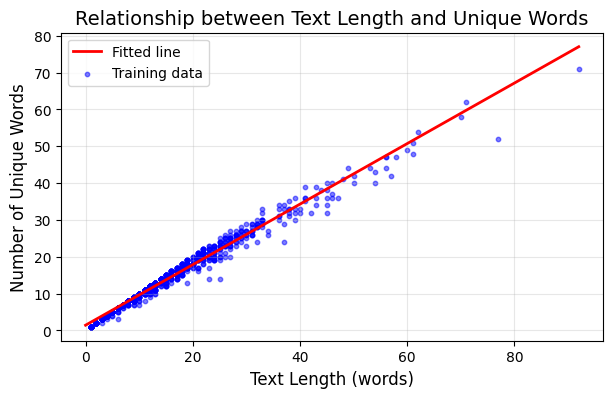

In [8]:
# Let's visualize what the model learned
plt.figure(figsize=(7, 4))

# Plot the fitted line
line_x = np.linspace(0, max(text_length), 100).reshape(-1, 1)
line_y = model.predict(line_x)
plt.plot(line_x, line_y, color='red', linewidth=2, label='Fitted line')

plt.scatter(text_length, unique_words, color='blue', s=10, alpha=0.5, label='Training data')
plt.xlabel('Text Length (words)', fontsize=12)
plt.ylabel('Number of Unique Words', fontsize=12)
plt.title('Relationship between Text Length and Unique Words', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


 The red line is what our model learned! Now we can use it to make predictions.
 However, we already see that for sentences with less than 5 total words, the predicted line(red) falls much higher than the real data (blue), showing that this area is not classified well.


**How to use the model for predictions:**

In [9]:
# Make predictions
new_texts = np.array([5, 20, 50])  # (shape is (3)) Texts with 5, 20, and 50 unique words
new_texts = new_texts.reshape(-1, 1)    # reshape to (3, 1) for sklearn

predictions = model.predict(new_texts)

print("=== Predictions ===")
for words, pred in zip(new_texts, predictions):
    print(f"Sentence with {words[0]} of total words → Predicted unique words: {pred:.1f}")

=== Predictions ===
Sentence with 5 of total words → Predicted unique words: 5.5
Sentence with 20 of total words → Predicted unique words: 17.8
Sentence with 50 of total words → Predicted unique words: 42.5


 <details>

   <summary><b>Question</b>: Why do we need .reshape(-1, 1)?</summary>



 scikit-learn expects features to be in a 2D format where:

 - Rows = different instances (data points)
 - Columns = different features

 Even if we only have one feature, we need to format it as a 2D array. The `-1` tells NumPy to automatically figure out that dimension based on the data length.
 ```python
 # This is 1D (won't work):
 x = np.array([1, 2, 3])  # Shape: (3,)
 # This is 2D (will work):
 x = np.array([[1], [2], [3]])  # Shape: (3, 1)
 # or
 x = np.array([1, 2, 3]).reshape(-1, 1)  # Shape: (3, 1)
 ```
 </details>

### Example 2: Linear Regression -  with Text Features

<!-- Now let's use `DictVectorizer` from the previous notebook to create features from text data! -->
<!-- Now let's use the real Yelp dataset to predict the rating  -->
**Scenario**: Now let's predict a Yelp review rating from a text, based on its linguistic features.

For this scenarios the we have for each review a string, which we will process to extract linguistic features into a dictionary. Like notebook M1.1 we will use `DictVectorizer` to vectorize them. The dataset also has a label $y$ for each instance, which is a rating from 1 to 5 (only integers) specifying how well the yelp user rated the service. 

In [10]:
# We use the loaded yelp dataset again, but now really looking at the data (not just the number of words ;))
dataset = dataset_yelp.shuffle(seed=42)
print(f"Dataset loaded! Number of examples: {len(dataset)}")
dataset[0]

Dataset loaded! Number of examples: 50000


{'label': 1,
 'text': "OK so I love a bobbie, i'll repeat I love a bobbie and I am a sucker for turkey day leftovers.  That being said I would give this place 1 star if it wasn't for that one sandwich.  Their bread is dry, the prices are kind of expensive and the service in any of the caps I have ever been to isn't anything spectacular (I have been to this one the most).  I guess the cap pastrami is OK too but their cold subs are tasteless, just horrible, and this is usually my favorite type of sandwich especially on a hot summer day. I recently got a small turkey sandwich with all the fixings and I ate half of it and I just gave up on it, it might have been the worst turkey sandwich I have ever had in my like and I am not fooling. The bread is the most important part of a sandwich and that is the number one thing caps is lacking, also their toppings on cold subs are plain so the whole thing comes over as boring filler."}

#### Let's extract some features!

Real text is messy! We need to extract features from it. Let's create some simple linguistic features: count how many question marks, exclamation marks are in the text, as well as counting some positive and negative sentiment words.

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

In [12]:
def extract_review_features(text):
    """Extract linguistic features from review text."""
    words = text.split()
    
    # Sentiment indicators
    positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'wonderful', 
                     'best', 'perfect', 'recommend', 'happy', 'best', 'fantastic']
    negative_words = ['bad', 'terrible', 'awful', 'hate', 'worst', 'boring', 
                     'poor', 'waste', 'disappointed', 'useless', 'disgusting', 'gross']
    
    text_lower = text.lower()
    
    features = {
        'text_length': len(text),
        'num_words': len(words),
        'exclamation_marks': text.count('!'),
        'question_marks': text.count('?'),
        'positive_words': sum(1 for word in positive_words if word in text_lower),
        'negative_words': sum(1 for word in negative_words if word in text_lower),
        'has_thanks': int('thank' in text_lower or 'thanks' in text_lower)
    }

    return features

**Vectorizing the data**: Remember from last time that we need to use DictVectorizer function using either
1. Via `fit_transform` one go for the full dataset and split afterward (as we do now), 
2. Or we fit on full data and transform separatly (if it is too compute intensive to do fit_transform in one go)

In [13]:
# Extract features and convert ratings to 0-5 scale if needed
features_list = [extract_review_features(example['text']) for example in dataset]
ratings = np.array([example['label'] for example in dataset])  # Assuming 0-5 or convert

# Vectorize
vec = DictVectorizer(sparse=False)
X = vec.fit_transform(features_list)

# Split data without shuffling (data already shuffled before)
X_train, X_test, y_train, y_test = train_test_split(
    X, ratings, test_size=0.2, random_state=42, shuffle=True
)


In [14]:
print("Feature matrix shape:", X.shape)

x_sample = dataset[5]
x_sample_text = x_sample['text']
y_sample = x_sample['label']
print(f"First instance text: {x_sample_text}")
print(f"First instance label: {y_sample}")

x_sample_features = extract_review_features(x_sample_text)
print("\nExtracted features for the first instance:")
# print each feature name with its value for the first instance
for name, value in x_sample_features.items():
    print(f" - {name}: {value}")

Feature matrix shape: (50000, 7)
First instance text: i'm usually a much sweeter kind of gal but this place is run by people who are dumb as rocks.\n\n2 young gals who fall into the uber granola category but without any knowledge of nutrition.  i get the low pay grade but at least feed me some bs when i ask a question or look it up.\n\nthere were 3 kinds of manuka honey - 2 of which i was familiar with and one i was not sure of their grading system - ie. what is \"silver\" = ? amber such and such?\n\nconvenient since they are close by but my next purchase will be from amazon - at least i can read up on the reviews there and it is cheaper.
First instance label: 1

Extracted features for the first instance:
 - text_length: 592
 - num_words: 120
 - exclamation_marks: 0
 - question_marks: 2
 - positive_words: 0
 - negative_words: 0
 - has_thanks: 0


 Notice how `DictVectorizer` handled both numerical features (question_marks, num_words) and categorical features (has_thanks). 

#### Let's train our model!

In [15]:
# Train model
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

# Evaluate
train_score = model_reg.score(X_train, y_train)
test_score = model_reg.score(X_test, y_test)
print(f"\nR² score on training: {train_score:.3f}")
print(f"R² score on test: {test_score:.3f}")


R² score on training: 0.286
R² score on test: 0.296


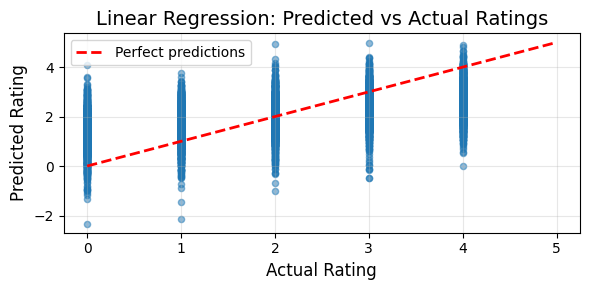

In [16]:
# Scatter plot: predicted vs actual ratings
y_pred = model_reg.predict(X_test)

plt.figure(figsize=(6,3))
plt.scatter(y_test, y_pred, alpha=0.5, s=20)
plt.plot([0, 5], [0, 5], 'r--', lw=2, label='Perfect predictions')
plt.xlabel('Actual Rating', fontsize=12)
plt.ylabel('Predicted Rating', fontsize=12)
plt.title('Linear Regression: Predicted vs Actual Ratings', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observation:**
- We see that the predicted and actual reviews follow a similar horizontal line, so if a movie has a higher actual rating (e.g. 4) than our trained model (which only sees the text features) also predicts it to have a higher score compared to reviews with lower actual rating. 
- For regression evaluating how well the model does is a bit more difficult than classification. Some measurements are the mean error or the mean squared error, but we will leave this for later discussion.

#### Visualizing Feature Importance

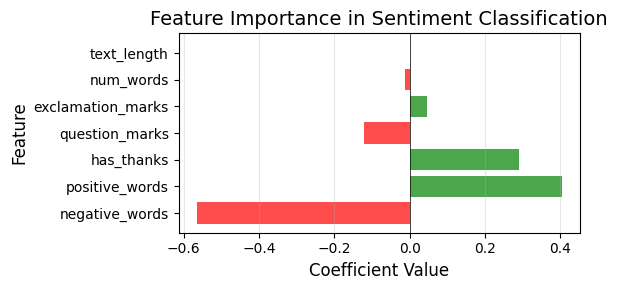


This means: predicted_review_rating ≈ +0.05 × exclamation_marks + +0.29 × has_thanks + -0.56 × negative_words + -0.01 × num_words + +0.40 × positive_words + -0.12 × question_marks + +0.00 × text_length + 1.86


In [17]:
def plot_feature_importance_bar(feat_names, feat_coefs, figsize=(6,3)):
    """
    Plots a horizontal bar chart of feature importance.
    Args:
        feature_importance: list of (feature_name, coefficient) tuples, sorted by importance.
        figsize: tuple, size of the figure.
    """
    feature_importance = sorted(
        zip(feat_names, feat_coefs), 
        key=lambda x: abs(x[1]), 
        reverse=True
    )
    plt.figure(figsize=figsize)
    names = [name for name, _ in feature_importance]
    coefs = [coef for _, coef in feature_importance]
    colors = ['green' if c > 0 else 'red' for c in coefs]

    plt.barh(names, coefs, color=colors, alpha=0.7)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Feature Importance in Sentiment Classification', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

feature_names = vec.get_feature_names_out()
plot_feature_importance_bar(feature_names, model_reg.coef_, figsize=(6,3))
func_str = create_equation_string(feature_names, model_reg.coef_, model_reg.intercept_)
print(f"\nThis means: predicted_review_rating ≈ {func_str}")

**Observation:** Looking at the coefficients, we can see which linguistic features are associated with higher ratings. Remember: positive coefficients increase the rating prediction, negative coefficients decrease it.


 <details>
   <summary><b>Question</b>: Which features seem most important for formality?</summary>

 Look at the coefficients with the largest absolute values (ignoring the sign). These have the biggest impact on the prediction. Compare your findings with your intuition about what makes text formal!

 </details>

## 3. Logistic Regression

 <!-- ### From Numbers to Categories -->
 Linear regression predicts **numbers** (formality scores, text length, etc.). But what if we want to predict **categories**?
 - Is this email spam or not spam?
 - Is this review positive or negative?
 - Is this text in English, Dutch, or German?

 This is called **classification**, and **Logistic Regression** is one of the simplest and most effective classifiers!

### How Does Logistic Regression Work?

 Despite its name, logistic regression is used for **classification**, not regression!

 Instead of predicting a number directly, it:
 1. Computes a score (similar to linear regression)
 2. Passes that score through a **sigmoid function** that squashes it between 0 and 1
 3. Interprets this as a probability: P(class = positive)

 If P > 0.5, predict positive class; otherwise predict negative class.

### The Sigmoid function

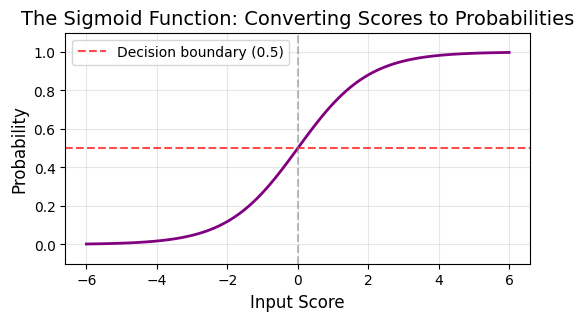

In [18]:
# Let's visualize the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-6, 6, 100)
y = sigmoid(x)

plt.figure(figsize=(6,3))
plt.plot(x, y, linewidth=2, color='purple')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Decision boundary (0.5)')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Input Score', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('The Sigmoid Function: Converting Scores to Probabilities', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(-0.1, 1.1)
plt.show()


 **Key insight**: No matter how large or small the input score, the output is always between 0 and 1, making it a valid probability!


  <details>
   <summary><b>Self-check questions</b></summary>

The sigmoid is just an operation like any other, but to get some idea of what values you expect for input output, can you estimate for the following input, what the sigmoid would look like?
For each of these estimate what the expected values would be (let's say the mean and standard deviation)?
- Input: the ages of everyone in your cities.
- Input: this scoring function for an input sentence: `y= 1*num_positive_words -1*num_negative_words`. 
 </details>

### The Logistic Regression Model

While linear regression predicts values directly, logistic regression predicts the probability of a class. It does this in two steps:

**Step 1: Compute a score (just like linear regression)**

$$z = w_0 + \sum_{i=1}^{n} w_i \cdot x_i$$

**Step 2: Apply the sigmoid function to get a probability**

$$P(y=1|x) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

Where:
- $P(y=1|x)$ = probability that the input belongs to the positive class
- $\sigma$ = the sigmoid function
- $w_0$ = intercept (bias)
- $w_i$ = coefficient for feature $i$
- $x_i$ = value of feature $i$

**Training the model**: When we call `.fit()`, the algorithm finds weights that minimize the **log loss** (also called **cross-entropy loss**):

$$\text{Log Loss} = -\frac{1}{m} \sum_{j=1}^{m} [y_j \log(\hat{p}_j) + (1-y_j) \log(1-\hat{p}_j)]$$

- This measures how well our predicted probabilities match the actual labels
- Lower log loss = better predictions
- Unlike linear regression (which has a closed-form solution), logistic regression uses iterative optimization (like gradient descent) to find the best weights

**Making predictions**: Once trained, we predict class 1 if $P(y=1|x) > 0.5$, otherwise class 0.

### Example Sentiment Classification - IMDB
Let's classify text as positive or negative based on linguistic features. We will use the IMDB dataset which only contains binary labels: Positive and Negative, which makes this a much easier classification task.

In [19]:
# Load a simple sentiment dataset, we'll use the 'imdb' dataset which contains movie reviews
print("Loading dataset... (this may take a moment)")
imdb_dataset = load_dataset('stanfordnlp/imdb', split='train')  # Load only first 100 examples for speed
print(f"\nDataset loaded! Number of examples: {len(imdb_dataset)}")

# shuffle and take the first 1000 examples for quicker processing
imdb_dataset = imdb_dataset.shuffle(seed=42)

Loading dataset... (this may take a moment)

Dataset loaded! Number of examples: 25000


In [20]:
# This time we use the first 1000 samples
dataset = imdb_dataset.select(range(1000))  # Use only first 100 examples for speed
print(f"\nDataset loaded! Number of examples: {len(dataset)}")
print(f"Features: {dataset.features}")

# Look at a few examples
print("\n=== Example Reviews ===")
for i in range(2):
    print(f"Review {i+1}:")
    print(f"- Text: {dataset[i]['text'][:200]}...")  # First 200 characters
    print(f"- Sentiment: {'Positive' if dataset['label'][i] == 1 else 'Negative'}")



Dataset loaded! Number of examples: 1000
Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}

=== Example Reviews ===
Review 1:
- Text: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. F...
- Sentiment: Positive
Review 2:
- Text: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub y...
- Sentiment: Positive


**Let's extract some features!**
- We use the same simple feature extractor from the yelp dataset for now.

In [21]:
# Extract features for all reviews
features_list = [extract_review_features(example['text']) for example in dataset]
labels = np.array([label for label in dataset['label']])

print(f"Extracted features from {len(features_list)} reviews")
print("Example features:", features_list[0])

Extracted features from 1000 reviews
Example features: {'text_length': 758, 'num_words': 125, 'exclamation_marks': 3, 'question_marks': 1, 'positive_words': 1, 'negative_words': 0, 'has_thanks': 0}


In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
# Vectorize the features
vec_real = DictVectorizer(sparse=False)
X_real = vec_real.fit_transform(features_list)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_real, labels, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 800
Test set size: 200


In [24]:
# Train the model
clf_real = LogisticRegression(max_iter=1000, random_state=42)
clf_real.fit(X_train, y_train)

# Evaluate
train_accuracy = clf_real.score(X_train, y_train)
test_accuracy = clf_real.score(X_test, y_test)

print(f"\n=== Model Performance ===")
print(f"Training accuracy: {train_accuracy:.2%}")
print(f"Test accuracy: {test_accuracy:.2%}")



=== Model Performance ===
Training accuracy: 76.12%
Test accuracy: 77.00%


#### Interpreting Logistic Regression Coefficients
The coefficients work similarly to linear regression, but now they indicate which features push the prediction toward the positive class (sentiment=1) or negative class (sentiment=0). Positive coefficients increase the probability of positive sentiment, while negative coefficients suggest negative sentiment.

In [25]:
# Look at feature importance
print("=== Most Important Features ===\n")
feature_names_real = vec_real.get_feature_names_out()
coefficients_real = clf_real.coef_[0]

# Sort by absolute coefficient value
feature_importance_real = sorted(
    zip(feature_names_real, coefficients_real), 
    key=lambda x: abs(x[1]), 
    reverse=True
)

for name, coef in feature_importance_real:
    direction = "→ Positive reviews" if coef > 0 else "→ Negative reviews"
    print(f"{name:20s}: {coef:+.2f}  {direction}")

print(f"\nIntercept: {clf_real.intercept_[0]:.2f}")
# Create the equation string
func_str_real = create_equation_string(feature_names_real, clf_real.coef_[0], clf_real.intercept_[0])
print(f"\nThis means: sentiment_score ≈ Softmax({func_str_real})")

=== Most Important Features ===

negative_words      : -1.35  → Negative reviews
positive_words      : +0.65  → Positive reviews
has_thanks          : +0.56  → Positive reviews
question_marks      : -0.40  → Negative reviews
exclamation_marks   : -0.00  → Negative reviews
num_words           : +0.00  → Positive reviews
text_length         : -0.00  → Negative reviews

Intercept: -0.01

This means: sentiment_score ≈ Softmax(-0.00 × exclamation_marks + +0.56 × has_thanks + -1.35 × negative_words + +0.00 × num_words + +0.65 × positive_words + -0.40 × question_marks + -0.00 × text_length + -0.01)


#### Visualizing Feature Importance

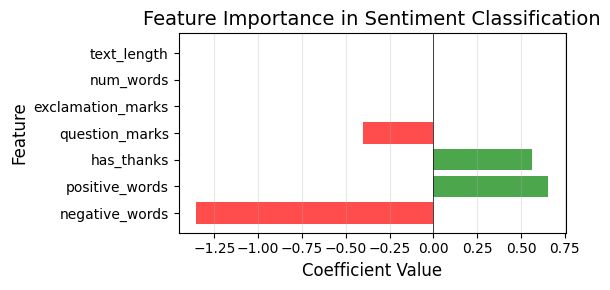

In [26]:
plot_feature_importance_bar(feature_names_real, coefficients_real, figsize=(6,3))

**Observation**: This is very similar to the plot from the Yelp sentiment regression model. Except that exlamation marks now also has no effect here. These similarities are ofcourse natural given the simplicity of the features and given that both are sentiment prediction tasks.

### Making Predictions
 Logistic regression can give us two things:
 1. **Hard predictions**: The predicted class (0 or 1)
 2. **Soft predictions**: The probability of each class

  Let's test our trained model on some completely new reviews

In [27]:
# Create some test reviews
test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it. Best film I've seen all year!",
    "Terrible waste of time. The plot was boring and the acting was awful. Would not recommend.",
    "It was okay, nothing special. Some parts were good, others not so much.",
]

# Extract features and make predictions
test_features = [extract_review_features(review) for review in test_reviews]
X_test_new = vec_real.transform(test_features)

predictions = clf_real.predict(X_test_new)
probabilities = clf_real.predict_proba(X_test_new)

print("=== Predictions on New Reviews ===\n")
for i, (review, pred, prob) in enumerate(zip(test_reviews, predictions, probabilities), 1):
    sentiment = "Positive" if pred == 1 else "Negative"
    confidence = prob[pred] * 100
    
    print(f"Review {i}:")
    print(f'"{review}"')
    print(f"\nPrediction: {sentiment}")
    print(f"Confidence: {confidence:.1f}%")
    print(f"Probabilities: [Negative: {prob[0]:.3f}, Positive: {prob[1]:.3f}]")
    print("-" * 80)
    print()


=== Predictions on New Reviews ===

Review 1:
"This movie was absolutely amazing! I loved every minute of it. Best film I've seen all year!"

Prediction: Positive
Confidence: 93.1%
Probabilities: [Negative: 0.069, Positive: 0.931]
--------------------------------------------------------------------------------

Review 2:
"Terrible waste of time. The plot was boring and the acting was awful. Would not recommend."

Prediction: Negative
Confidence: 99.1%
Probabilities: [Negative: 0.991, Positive: 0.009]
--------------------------------------------------------------------------------

Review 3:
"It was okay, nothing special. Some parts were good, others not so much."

Prediction: Positive
Confidence: 65.8%
Probabilities: [Negative: 0.342, Positive: 0.658]
--------------------------------------------------------------------------------



## 4. Self-Check Questions
Test your understanding by answering these questions. Try to answer them before looking up the answers in the notebook!
1. What's the fundamental difference between linear and logistic regression?
   - When would you use each one?
   - What type of output does each produce?
2. What does the `.fit()` method actually do?
   - For linear regression, what is being minimized?
   - For logistic regression, what loss function is being optimized?
3. Why do we need the sigmoid function in logistic regression?
   - What would happen if we used linear regression for classification instead?
4. Could you implement a Linear or Logistic Regression algorithm for a new task? 
5. How would you determine which features are most important based on the learned coeficients of a model?

### Additional Resources
 - [Scikit-learn Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Scikit-learn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 - [HuggingFace Datasets](https://huggingface.co/docs/datasets/)
 - [Understanding the sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function)